# week 1

In [1]:
from typing import Optional

import cv2
import numpy as np
import matplotlib.pyplot as plt


## Homogeneous coordinates

In [2]:
def Pi(arr: np.ndarray) -> np.ndarray:
    """
    Also called Pi(x)

    Converts from homogeneous to inhomogeneous coordinates
    """
    return arr[:-1] / arr[-1]


def InvPi(arr: np.ndarray) -> np.ndarray:
    """
    Converts from inhomogeneous to homogeneous coordinates
    """
    return np.vstack((arr, np.ones(arr.shape[1])))


def camera_matrix(
    f: float=1.,
    delta: list[float]=(0,0),
    alpha: float=1.,
    beta: float=0.,
) -> np.ndarray:
    """
    f: focal length
    delta: principal point offset
    alpha: ratio of focal lengths f_y / f_x. Alpha!=1 means non-square pixels
    beta: skew factor with slope = beta / alpha. Beta!=0 means non-orthogonal axes

    Returns the camera matrix
    """
    return np.array([[f,  beta*f, delta[0]],
                     [0, alpha*f, delta[1]],
                     [0,       0,        1]])


def shortest_distance_to_line(ps: np.ndarray, l: np.ndarray) -> float:
    """
    Returns the shortest distance besteen each point in ps to a line l.
    """
    return abs(l.T @ ps) / (abs(ps[-1]) * np.linalg.norm(l[:-1]))

In [3]:
l1 = np.array([[np.sqrt(2)/2, np.sqrt(2)/2, -1]]).T
l2 = np.array([[2, 2, -1]]).T
p1 = np.array([[0, 0, 1]]).T
p2 = np.array([[np.sqrt(2), np.sqrt(2), 1]]).T
p3 = np.array([[np.sqrt(2), np.sqrt(2), 4]]).T

ps = np.concatenate((p1, p2, p3), axis=1)
for l in [l1, l2]:
    print("Distance to line: ", shortest_distance_to_line(ps, l))


Distance to line:  [[1.  1.  0.5]]
Distance to line:  [[0.35355339 1.64644661 0.14644661]]


In [4]:
# 2d coordinates
p1 = np.array([[1, 2, 1]]).T
p2 = np.array([[4, 2, 2]]).T
p3 = np.array([[6, 4, -1]]).T
p4 = np.array([[5, 3, 0.5]]).T

print("Homogeneous to inhomogeneous 2d")
for _p in [p1, p2, p3, p4]:
    print(f"Point: {_p}")
    print(f"Inhomogeneous: {Pi(_p)}")

# 3d coordinates
P1 = np.array([[1, 10, -3, 1]]).T
P2 = np.array([[2, -4, 1.1, 2]]).T
P3 = np.array([[0, 0, -1, 10]]).T
P4 = np.array([[-15, 3, 6, 3]]).T
print("\nHomogeneous to inhomogeneous 3d")

for _p in [P1, P2, P3, P4]:
    print(f"Point: {_p}")
    print(f"Inhomogeneous: {Pi(_p)}")

Homogeneous to inhomogeneous 2d
Point: [[1]
 [2]
 [1]]
Inhomogeneous: [[1.]
 [2.]]
Point: [[4]
 [2]
 [2]]
Inhomogeneous: [[2.]
 [1.]]
Point: [[ 6]
 [ 4]
 [-1]]
Inhomogeneous: [[-6.]
 [-4.]]
Point: [[5. ]
 [3. ]
 [0.5]]
Inhomogeneous: [[10.]
 [ 6.]]

Homogeneous to inhomogeneous 3d
Point: [[ 1]
 [10]
 [-3]
 [ 1]]
Inhomogeneous: [[ 1.]
 [10.]
 [-3.]]
Point: [[ 2. ]
 [-4. ]
 [ 1.1]
 [ 2. ]]
Inhomogeneous: [[ 1.  ]
 [-2.  ]
 [ 0.55]]
Point: [[ 0]
 [ 0]
 [-1]
 [10]]
Inhomogeneous: [[ 0. ]
 [ 0. ]
 [-0.1]]
Point: [[-15]
 [  3]
 [  6]
 [  3]]
Inhomogeneous: [[-5.]
 [ 1.]
 [ 2.]]


In [5]:

def box3d(n: int=16) -> np.ndarray:
    import itertools as it

    points = []
    N = tuple(np.linspace(-1, 1, n))
    
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, ) * n, (j, ) * n, N])))
    
    return np.hstack(points) / 2

def projectpoints(
    K: np.ndarray,
    R: np.ndarray=np.eye(3),
    t: np.ndarray=np.zeros((3, 1)),
    Q: Optional[np.ndarray]=None,
    *,
    radial_dist_factors: Optional[list[float]]=None,
) -> np.ndarray:
    """
    K: Camera matrix
    R: Rotation matrix
    t: Translation vector
    Q: 3D points
    radial_dist_factors: the coefficients of the radial distortion polynomial
        dr(r) = k_3 * r**2 + k_5 * r**4 + k_7 * r**6 + ...
    """

    assert (Q is not None) or (radial_dist_factors is None), "Q must be provided if radial_dist_factors is provided"

    projection_matrix = K @ np.concatenate((R,t), axis=1)

    if Q is None:
        return projection_matrix
    
    if radial_dist_factors is not None:
        # regid transform
        _tmp = Pi(np.concatenate((R,t), axis=1) @ Q)
        
        # radial distortion
        _norm = np.linalg.norm(_tmp, axis=0)
        _scale = 1 + np.stack([c * _norm ** (2*i)
                            for i, c in enumerate(radial_dist_factors, start=1)]).sum(axis=0)
        _tmp = _tmp * _scale
        
        # camera projection
        return K @ InvPi(_tmp)

    return projection_matrix @ Q



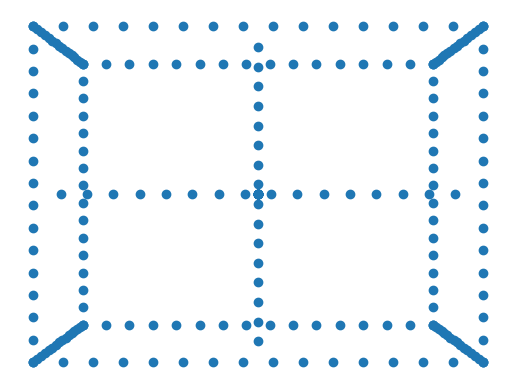

In [6]:
K = np.eye(3)
R = lambda theta: np.array([[np.cos(theta), 0, np.sin(theta)],
                            [0, 1, 0], 
                            [-np.sin(theta), 0, np.cos(theta)]])
t = np.zeros((3, 1))
t[2] = 4
Q = InvPi(box3d())

plt.scatter(*Pi(projectpoints(K, R(0), t, Q)))
plt.axis('off')
plt.show()


### quiz

In [7]:
p = np.array([[2, 4, 3]]).T
l = np.array([[1, 2, 2]]).T
print(shortest_distance_to_line(p, l))


K = camera_matrix(1720, np.array([680, 610]))
R = cv2.Rodrigues(np.array([-0.1, 0.1, -0.2]))[0]
t = np.array([[0.09], [0.05], [0.05]])
Q = InvPi(np.array([[-0.03, 0.01, 0.59]]).T)
Pi(projectpoints(K, R, t, Q))

[[2.38513918]]


array([[1023.50377104],
       [ 930.29756751]])

# Week 2

## distortion

In [8]:
def undistortImage(
    img: np.ndarray,
    radial_dist_factors: np.ndarray,
    K: np.ndarray,
) -> np.ndarray:
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    p = np.stack((x, y, np.ones_like(x))).reshape(3, -1)
    q = np.linalg.inv(K) @ p
    q_d = projectpoints(np.eye(3), Q=InvPi(q), radial_dist_factors=radial_dist_factors)
    p_d = K @ q_d
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    img_undistorted = cv2.remap(img, x_d, y_d, cv2.INTER_LINEAR)
    return img_undistorted

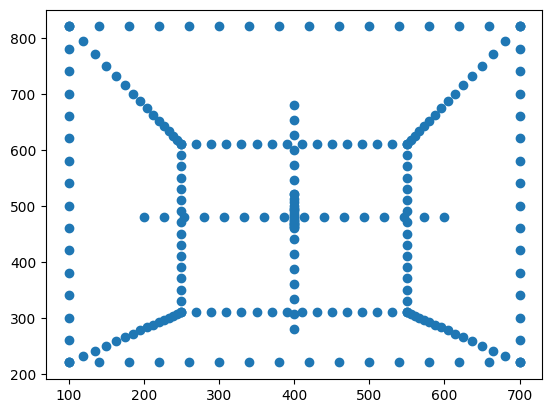

[100. 220.] [700. 820.]


array([[100.],
       [220.]])

In [9]:
K = camera_matrix(
    f=600,
    alpha=1,
    beta=0,
    delta=(400, 400)
)

R = np.eye(3)
t = np.array([[0, .2, 1.5]]).T
Q = InvPi(box3d())

points = Pi(projectpoints(K, R, t, Q))
plt.scatter(*points)
plt.show()

print(points.min(axis=1), points.max(axis=1))

Pi(projectpoints(K, R, t, np.array([[-0.5, -0.5, -0.5, 1]]).T))


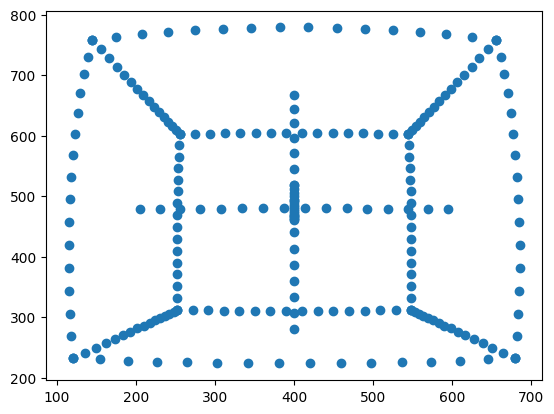

In [10]:
r_coefs = [-0.2]

p_d = Pi(projectpoints(K, R, t, Q, radial_dist_factors=r_coefs))

plt.scatter(*p_d)
plt.show()

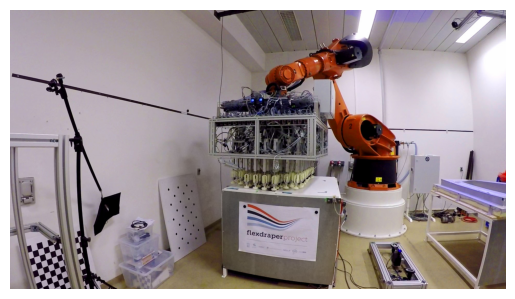

In [11]:
img = cv2.imread('week02/gopro_robot.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
 
plt.imshow(img)
plt.axis('off')
plt.show()

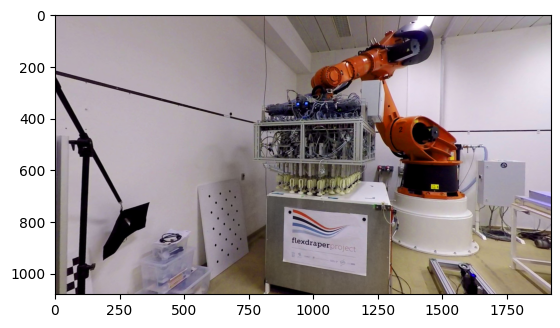

In [12]:
K = camera_matrix(.455732*img.shape[1], (img.shape[1]//2, img.shape[0]//2))
r_coefs = [-0.245031, 0.071524, -0.00994978]
img_undistorted = undistortImage(img, r_coefs, K)
plt.imshow(img_undistorted)
plt.show()

## homography

In [13]:
def normalize2d(ps: np.ndarray) -> np.ndarray:
    """
    Creates a 2D normalization matrix
    where T_inv^-1 @ ps = ps_normalized
    """

    mu = ps.mean(axis=1)
    sigma = ps.std(axis=1)
    T_inv = np.array([[sigma[0], 0, mu[0]],
                  [0, sigma[1], mu[1]],
                  [0, 0, 1]])
    return T_inv


CrossOp = lambda v: np.array([[    0, -v[2],  v[1]],
                              [ v[2],     0, -v[0]],
                              [-v[1],  v[0],     0]])


def hest(
    ps: np.ndarray,
    qs: np.ndarray,
    *,
    normalize: bool=True
) -> np.ndarray:
    """
    Estimates the homography matrix between two sets of points where
    Pi(p) = Pi(H @ q)
    """
    ps = InvPi(ps)
    qs = InvPi(qs)

    if normalize:
        Tp_inv = normalize2d(ps)
        Tp = np.linalg.inv(Tp_inv)

        Tq_inv = normalize2d(qs)
        Tq = np.linalg.inv(Tq_inv)

        ps = Tp @ ps
        qs = Tq @ qs
    
    B = np.vstack([np.kron(q, CrossOp(p)) for p, q in zip(ps.T, qs.T)])
    _, _, V = np.linalg.svd(B)

    H_pred = V[-1].reshape(3, 3).T

    if normalize:
        return Tp_inv @ H_pred @ Tq
    return H_pred


In [14]:
p1 = np.array([[1, 1]]).T
p2 = np.array([[0, 3]]).T
p3 = np.array([[2, 3]]).T
p4 = np.array([[2, 4]]).T

H = np.array([[-2,  0, 1],
              [ 1, -2, 0],
              [ 0,  0, 3]])

points = InvPi(np.concatenate((p1, p2, p3, p4), axis=1))

points2 = H @ points
H_pred = hest(Pi(points), Pi(points2))
points_pred = H_pred @ points2
print(np.array2string(Pi(points_pred), precision=2, suppress_small=True))

[[1. 0. 2. 2.]
 [1. 3. 3. 4.]]


In [15]:
q2 = np.random.randn(2, 100)
q2h = InvPi(q2)
H_true = H
q1h = H_true@q2h
q1 = Pi(q1h)

H_pred = hest(q1, q2, normalize=True)
print(np.array2string(H_true, precision=2, suppress_small=True))
print(np.array2string(H_pred, precision=2, suppress_small=True))

[[-2  0  1]
 [ 1 -2  0]
 [ 0  0  3]]
[[ 0.39  0.   -0.19]
 [-0.19  0.39  0.  ]
 [ 0.    0.   -0.58]]


# Week 3

## Epipolar geometry

In [16]:
from scipy.spatial.transform import Rotation

K = camera_matrix(1000, (300, 200))

R1 = np.eye(3)
t1 = np.zeros((3, 1))

R2 = Rotation.from_euler('xyz', [.7, -.5, .8]).as_matrix()
t2 = np.array([[.2, 2, 1]]).T

Q = InvPi(np.array([[1, .5, 4]]).T)

q1 = projectpoints(K, R1, t1, Q)
q2 = projectpoints(K, R2, t2, Q)

p1 = projectpoints(np.eye(3), R1, t1, Q)
p2 = projectpoints(np.eye(3), R2, t2, Q)


In [17]:
E = CrossOp(t2[:,0]) @ R2
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)

assert np.isclose(p2.T @ E @ p1, 0), "Essential matrix is wrong"
assert np.isclose(q2.T @ F @ q1, 0), "Fundamental matrix is wrong"


In [18]:
F @ p1

array([[ 7.16724268e-03],
       [ 3.72647737e-04],
       [-4.40344636e+00]])

In [19]:
data = np.load('week03/TwoImageDataCar.npy', allow_pickle=True).item()

# img1 = data['im1']
# R1 = data['R1']
# t1 = data['t1']
# img2 = data['im2']
# R2 = data['R2']
# t2 = data['t2']
# K = data['K']

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(img1)
# ax[1].imshow(img2)
# for a in ax:
#     a.axis('off')
# plt.show()

## Triangulation

In [20]:
def triangulate(qs: np.ndarray, Ps: np.ndarray) -> np.ndarray:
    """
    qs: list of 2d points shape (2, n)
    Ps: list of 3x4 projection matrices

    Triangulates points qs from two different views Ps
    """
    if qs.shape[0] == 3:
        qs = Pi(qs)

    B = np.vstack([P[2][None, :] * qs[:, i][:, None] - P[:-1] for i, P in enumerate(Ps)])
    _, _, V = np.linalg.svd(B)

    return V[-1][:, None]


In [21]:
Q_pred = triangulate(
    Pi(np.concatenate((q1, q2), axis=1)),
    (
        projectpoints(K, R1, t1),
        projectpoints(K, R2, t2)
    )
)

Pi(Q_pred)

array([[1. ],
       [0.5],
       [4. ]])

# Week 4

# Week 5

# Week 6

# Week 7

# Week 8

# Week 9

# Week 10

# Week 11

# Week 12